## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: cm.fabric-testbed.net Orchestrator Host: orchestrator.fabric-testbed.net


In [3]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

In [4]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: TACC: { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { bw: 100/100 Gbps}
		TACC_MAX: TrunkPort { bw: 100/100 Gbps}
NCSA: { cpu: 6/6 , core: 192/192 , ram: 1,536/1,536 G, disk: 60,600/60,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		NVME-P4510:  NVME P4510 { disk: 9,600/9,600 G, unit: 10/10 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }


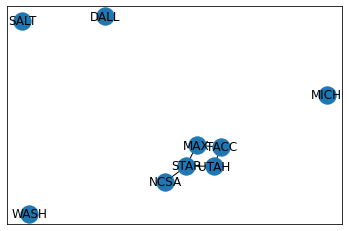

In [5]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

In [9]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()


# Add node
n1 = t.add_node(name='master_node', site='MAX')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=4, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Add node
n2 = t.add_node(name='client_node', site='MAX')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Add node
n3 = t.add_node(name='master_node_2', site='MAX')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-Kubernetes-Hello-World', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "a7dcc307-7713-4883-9008-37fa95fc6307",
    "lease_end": "2021-11-04 03:22:32",
    "pending_state": "None_",
    "reservation_id": "b759e74b-6b6a-4594-9673-af6af5ecc8cd",
    "reservation_state": "Unknown",
    "slice_id": "fef82abf-d47d-4749-a09d-e25d8c0199b9"
}, {
    "graph_node_id": "a9a5eb1d-18d2-4d32-a70f-9c95507f6330",
    "lease_end": "2021-11-04 03:22:32",
    "pending_state": "None_",
    "reservation_id": "3929b10c-48ef-4a92-bcd9-65518889f539",
    "reservation_state": "Unknown",
    "slice_id": "fef82abf-d47d-4749-a09d-e25d8c0199b9"
}, {
    "graph_node_id": "07f96276-ee5b-439b-92cc-bdc7023f9ccb",
    "lease_end": "2021-11-04 03:22:32",
    "pending_state": "None_",
    "reservation_id": "47f000b9-0dc5-434c-9433-860ac241db6c",
    "reservation_state": "Unknown",
    "slice_id": "fef82abf-d47d-4749-a09d-e25d8c0199b9"
}]


In [10]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id
print(slice_id)

fef82abf-d47d-4749-a09d-e25d8c0199b9


## Query Slices

In [12]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "e02ad13c-dba9-47c4-9826-09aeeb072e0f",
    "lease_end": "2021-11-04 02:39:26",
    "slice_id": "a0e8e3db-aa36-461c-b1c9-9585effebcb6",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "aafd2ca1-30d4-4291-b699-bc564a4e55ee",
    "lease_end": "2021-11-04 03:22:01",
    "slice_id": "902fe61f-ebcc-4119-a201-a2171751d213",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Closing"
}, {
    "graph_id": "76b61aab-99ec-4fbe-9a20-afbda0115c69",
    "lease_end": "2021-11-04 03:22:32",
    "slice_id": "fef82abf-d47d-4749-a09d-e25d8c0199b9",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "StableOK"
}]


## Query Slivers

In [13]:
slice_object = list(filter(lambda x: x.slice_id == slice_id, slices))[0]
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-0000051b\", \"instance_parent\": \"max-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "a7dcc307-7713-4883-9008-37fa95fc6307",
    "join_state": "NoJoin",
    "lease_end": "2021-11-04 03:22:32",
    "management_ip": "63.239.135.117",
    "name": "master_node",
    "notices": "Reservation b759e74b-6b6a-4594-9673-af6af5ecc8cd (Slice Slice-Kubernetes-Hello-World(fef82abf-d47d-4749-a09d-e25d8c0199b9) Graph Id:76b61aab-99ec-4fbe-9a20-afbda0115c69 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "b759e74b-6b6a-4594

## Sliver Status

In [14]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(sliver=s)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK

Sliver Status {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-0000051b\", \"instance_parent\": \"max-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "a7dcc307-7713-4883-9008-37fa95fc6307",
    "join_state": "NoJoin",
    "lease_end": "2021-11-04 03:22:32",
    "management_ip": "63.239.135.117",
    "name": "master_node",
    "notices": "Reservation b759e74b-6b6a-4594-9673-af6af5ecc8cd (Slice Slice-Kubernetes-Hello-World(fef82abf-d47d-4749-a09d-e25d8c0199b9) Graph Id:76b61aab-99ec-4fbe-9a20-afbda0115c69 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "b759e74b-6b6

## Work on the servers starts here.

### We are going to use paramiko to connect to our servers through ssh.

In [15]:
import paramiko

### We have two servers with two IPs.

In [16]:
master_node_ip = list(filter(lambda sliver : sliver.name == "master_node",slivers))[0].management_ip
master_node_ip

'63.239.135.117'

In [17]:
master_node_2_ip = list(filter(lambda sliver : sliver.name == "master_node_2",slivers))[0].management_ip
master_node_2_ip

'63.239.135.115'

In [18]:
client_node_ip = list(filter(lambda sliver : sliver.name == "client_node",slivers))[0].management_ip
client_node_ip

'63.239.135.112'

### Below, we connect to some nodes.

In [19]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
master_node = paramiko.SSHClient()
master_node.load_system_host_keys()
master_node.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

master_node.set_missing_host_key_policy(paramiko.AutoAddPolicy())
master_node.connect(master_node_ip,username='ubuntu',pkey = key)

master_node

In [20]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
master_node_2 = paramiko.SSHClient()
master_node_2.load_system_host_keys()
master_node_2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

master_node_2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
master_node_2.connect(master_node_2_ip,username='ubuntu',pkey = key)

master_node_2

In [24]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client_node = paramiko.SSHClient()
client_node.load_system_host_keys()
client_node.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client_node.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client_node.connect(client_node_ip,username='ubuntu',pkey = key)

client_node

### Connection should be established. Let's issue some test commands:

In [21]:
stdin, stdout, stderr = master_node.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [22]:
stdin, stdout, stderr = master_node.exec_command('ip addr')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:7c:b2:f2 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.122/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86246sec preferred_lft 86246sec
    inet6 fe80::f816:3eff:fe7c:b2f2/64 scope link 
       valid_lft forever preferred_lft forever




In [23]:
stdin, stdout, stderr = master_node.exec_command('curl https://ipinfo.io/ip')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

63.239.135.117
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0    145      0 --:--:-- --:--:-- --:--:--   145



### Now, let's do a quick ping experiment. Let's let each of the servers ping the other server.

In [25]:
stdin, stdout, stderr = client_node.exec_command('ping -c 10 ' + master_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.117 (63.239.135.117) 56(84) bytes of data.
64 bytes from 63.239.135.117: icmp_seq=1 ttl=63 time=0.907 ms
64 bytes from 63.239.135.117: icmp_seq=2 ttl=63 time=0.551 ms
64 bytes from 63.239.135.117: icmp_seq=3 ttl=63 time=0.553 ms
64 bytes from 63.239.135.117: icmp_seq=4 ttl=63 time=0.450 ms
64 bytes from 63.239.135.117: icmp_seq=5 ttl=63 time=0.466 ms
64 bytes from 63.239.135.117: icmp_seq=6 ttl=63 time=0.488 ms
64 bytes from 63.239.135.117: icmp_seq=7 ttl=63 time=0.317 ms
64 bytes from 63.239.135.117: icmp_seq=8 ttl=63 time=0.479 ms
64 bytes from 63.239.135.117: icmp_seq=9 ttl=63 time=0.309 ms
64 bytes from 63.239.135.117: icmp_seq=10 ttl=63 time=0.342 ms

--- 63.239.135.117 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9195ms
rtt min/avg/max/mdev = 0.309/0.486/0.907/0.163 ms




In [26]:
stdin, stdout, stderr = master_node.exec_command('ping -c 10 ' + client_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.112 (63.239.135.112) 56(84) bytes of data.
64 bytes from 63.239.135.112: icmp_seq=1 ttl=63 time=0.501 ms
64 bytes from 63.239.135.112: icmp_seq=2 ttl=63 time=0.395 ms
64 bytes from 63.239.135.112: icmp_seq=3 ttl=63 time=0.392 ms
64 bytes from 63.239.135.112: icmp_seq=4 ttl=63 time=0.358 ms
64 bytes from 63.239.135.112: icmp_seq=5 ttl=63 time=0.320 ms
64 bytes from 63.239.135.112: icmp_seq=6 ttl=63 time=0.420 ms
64 bytes from 63.239.135.112: icmp_seq=7 ttl=63 time=0.409 ms
64 bytes from 63.239.135.112: icmp_seq=8 ttl=63 time=0.385 ms
64 bytes from 63.239.135.112: icmp_seq=9 ttl=63 time=0.424 ms
64 bytes from 63.239.135.112: icmp_seq=10 ttl=63 time=0.460 ms

--- 63.239.135.112 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9198ms
rtt min/avg/max/mdev = 0.320/0.406/0.501/0.047 ms




### Ping experiment complete. Both nodes can see each other.

### Now, let's start a Kubernetes cluster on those two nodes.

We follow the instructions that we have here: https://github.com/apache/openwhisk-deploy-kube/blob/master/docs/k8s-diy-ubuntu.md

## Master node setup.

We now simply follow the instructions on our master node one by one.

In [27]:
stdin, stdout, stderr = master_node.exec_command('sudo apt update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [949 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [178 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8844 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [483 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [69.2 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [508 B]
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [647 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [106 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [12.8 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [21.9 kB]
Get:12 http://security.ubunt

In [28]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get install -y docker.io')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base libidn11 pigz runc
  ubuntu-fan
Suggested packages:
  ifupdown aufs-tools cgroupfs-mount | cgroup-lite debootstrap docker-doc
  rinse zfs-fuse | zfsutils
The following NEW packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base docker.io libidn11 pigz
  runc ubuntu-fan
0 upgraded, 9 newly installed, 0 to remove and 58 not upgraded.
Need to get 74.3 MB of archives.
After this operation, 360 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 bridge-utils amd64 1.6-2ubuntu1 [30.5 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 runc amd64 1.0.0~rc95-0ubuntu1~20.04.2 [4087 kB]
Get:4 http://nova.

In [29]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get update && sudo apt-get install -y apt-transport-https curl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
The following NEW packages will be installed:
  apt-transport-https
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 400 kB of archives.
After this operation, 164 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 apt-transport-https all 2.0.6 [4680 B]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.7 [161 kB]
Get:3 http://nova.cloud

In [30]:
stdin, stdout, stderr = master_node.exec_command('curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

OK




In [31]:
stdin, stdout, stderr = master_node.exec_command('cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list\ndeb https://apt.kubernetes.io/ kubernetes-xenial main\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [32]:
stdin, stdout, stderr = master_node.exec_command('cat /etc/apt/sources.list.d/kubernetes.list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [33]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:5 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [50.9 kB]
Fetched 60.3 kB in 1s (69.1 kB/s)
Reading package lists...




In [34]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get install -y kubernetes-cni=0.6.0-00 kubelet=1.11.2-00 kubeadm=1.11.2-00 kubectl=1.11.2-00')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cri-tools ebtables socat
The following NEW packages will be installed:
  cri-tools ebtables kubeadm kubectl kubelet kubernetes-cni socat
0 upgraded, 7 newly installed, 0 to remove and 56 not upgraded.
Need to get 59.5 MB of archives.
After this operation, 354 MB of additional disk space will be used.
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 ebtables amd64 2.0.11-3build1 [80.3 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 socat amd64 1.7.3.3-2 [323 kB]
Get:1 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 cri-tools amd64 1.19.0-00 [11.2 MB]
Get:2 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 kubernetes-cni amd64 0.6.0-00 [5910 kB]
Get:3 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 kubelet amd64 1.11.2-00 [23.2 MB]
Get:4 https://packages.cl

In [35]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-mark hold kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

kubelet set on hold.
kubeadm set on hold.
kubectl set on hold.




In [36]:
stdin, stdout, stderr = master_node.exec_command('sudo swapoff -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Skip the two cells below.

In [37]:
# stdin, stdout, stderr = master_node.exec_command('cat <<EOF | sudo tee /etc/docker/daemon.json\n{\n"exec-opts": ["native.cgroupdriver=systemd"]\n}\nEOF\n')
# print(stdout.read().decode("utf-8"))
# print(stderr.read().decode("utf-8"))

In [38]:
# stdin, stdout, stderr = master_node.exec_command('sudo systemctl enable docker && sudo systemctl daemon-reload && sudo systemctl restart docker')
# print(stdout.read().decode("utf-8"))
# print(stderr.read().decode("utf-8"))

### The setup part is complete. Now, we issue the kubeadm init command below:

In [39]:
stdin, stdout, stderr = master_node.exec_command('sudo kubeadm init --pod-network-cidr=192.168.0.0/16 --apiserver-advertise-address=0.0.0.0 --ignore-preflight-errors=SystemVerification')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

[init] using Kubernetes version: v1.11.10
[preflight] running pre-flight checks
[preflight] The system verification failed. Printing the output from the verification:
KERNEL_VERSION: 5.4.0-84-generic
CONFIG_NAMESPACES: enabled
CONFIG_NET_NS: enabled
CONFIG_PID_NS: enabled
CONFIG_IPC_NS: enabled
CONFIG_UTS_NS: enabled
CONFIG_CGROUPS: enabled
CONFIG_CGROUP_CPUACCT: enabled
CONFIG_CGROUP_DEVICE: enabled
CONFIG_CGROUP_FREEZER: enabled
CONFIG_CGROUP_SCHED: enabled
CONFIG_CPUSETS: enabled
CONFIG_MEMCG: enabled
CONFIG_INET: enabled
CONFIG_EXT4_FS: enabled
CONFIG_PROC_FS: enabled
CONFIG_NETFILTER_XT_TARGET_REDIRECT: enabled (as module)
CONFIG_NETFILTER_XT_MATCH_COMMENT: enabled (as module)
CONFIG_OVERLAY_FS: enabled (as module)
CONFIG_AUFS_FS: enabled (as module)
CONFIG_BLK_DEV_DM: enabled
DOCKER_VERSION: 20.10.7
OS: Linux
CGROUPS_CPU: enabled
CGROUPS_CPUACCT: enabled
CGROUPS_CPUSET: enabled
CGROUPS_DEVICES: enabled
CGROUPS_FREEZER: enabled
CGROUPS_MEMORY: enabled
[preflight/images] Pulling im

### As stated, the initialization was successful. Note that we need to save the join command somewhere, because we will need to use it later at the client.

In [40]:
stdin, stdout, stderr = master_node.exec_command('mkdir -p $HOME/.kube')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [41]:
stdin, stdout, stderr = master_node.exec_command('sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [42]:
stdin, stdout, stderr = master_node.exec_command('sudo chown $(id -u):$(id -g) $HOME/.kube/config')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [44]:
stdin, stdout, stderr = master_node.exec_command('kubectl apply -f https://docs.projectcalico.org/archive/v3.9/manifests/calico.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

configmap/calico-config created
customresourcedefinition.apiextensions.k8s.io/felixconfigurations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ipamblocks.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/blockaffinities.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ipamhandles.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ipamconfigs.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/bgppeers.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/bgpconfigurations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ippools.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/hostendpoints.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/clusterinformations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/globalnetworkpolicies.

In [45]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS    ROLES     AGE       VERSION
b759e74b-6b6a-4594-9673-af6af5ecc8cd-master-node   Ready     master    1m        v1.11.2




### It is now ready.

## Client side setup.

### We are now done with the server. Let's do the client. Remember, we are following the instructions in the link that we have previously mentioned.

In [46]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [949 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [178 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8844 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [483 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [69.2 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [508 B]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [647 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [106 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univers

In [47]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get install -y docker.io')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base libidn11 pigz runc
  ubuntu-fan
Suggested packages:
  ifupdown aufs-tools cgroupfs-mount | cgroup-lite debootstrap docker-doc
  rinse zfs-fuse | zfsutils
The following NEW packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base docker.io libidn11 pigz
  runc ubuntu-fan
0 upgraded, 9 newly installed, 0 to remove and 58 not upgraded.
Need to get 74.3 MB of archives.
After this operation, 360 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 bridge-utils amd64 1.6-2ubuntu1 [30.5 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 runc amd64 1.0.0~rc95-0ubuntu1~20.04.2 [4087 kB]
Get:4 http://nova.

In [48]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update && sudo apt-get install -y apt-transport-https curl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
The following NEW packages will be installed:
  apt-transport-https
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 400 kB of archives.
After this operation, 164 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 apt-transport-https all 2.0.6 [4680 B]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.7 [161 kB]
Get:3 http://nova.cloud

In [49]:
stdin, stdout, stderr = client_node.exec_command('curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

OK




In [50]:
stdin, stdout, stderr = client_node.exec_command('cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list\ndeb https://apt.kubernetes.io/ kubernetes-xenial main\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [51]:
stdin, stdout, stderr = client_node.exec_command('cat /etc/apt/sources.list.d/kubernetes.list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [52]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:5 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [50.9 kB]
Fetched 60.3 kB in 1s (77.0 kB/s)
Reading package lists...




In [53]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get install -y kubernetes-cni=0.6.0-00 kubelet=1.11.2-00 kubeadm=1.11.2-00 kubectl=1.11.2-00')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cri-tools ebtables socat
The following NEW packages will be installed:
  cri-tools ebtables kubeadm kubectl kubelet kubernetes-cni socat
0 upgraded, 7 newly installed, 0 to remove and 56 not upgraded.
Need to get 59.5 MB of archives.
After this operation, 354 MB of additional disk space will be used.
Get:1 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 cri-tools amd64 1.19.0-00 [11.2 MB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 ebtables amd64 2.0.11-3build1 [80.3 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 socat amd64 1.7.3.3-2 [323 kB]
Get:2 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 kubernetes-cni amd64 0.6.0-00 [5910 kB]
Get:3 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 kubelet amd64 1.11.2-00 [23.2 MB]
Get:4 https://packages.cl

In [54]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-mark hold kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

kubelet set on hold.
kubeadm set on hold.
kubectl set on hold.




In [55]:
stdin, stdout, stderr = client_node.exec_command('sudo swapoff -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [56]:
# stdin, stdout, stderr = client_node.exec_command('cat <<EOF | sudo tee /etc/docker/daemon.json\n{\n"exec-opts": ["native.cgroupdriver=systemd"]\n}\nEOF\n')
# print(stdout.read().decode("utf-8"))
# print(stderr.read().decode("utf-8"))

In [57]:
# stdin, stdout, stderr = client_node.exec_command('sudo systemctl enable docker && sudo systemctl daemon-reload && sudo systemctl restart docker')
# print(stdout.read().decode("utf-8"))
# print(stderr.read().decode("utf-8"))

### The setup part is complete. Now we need to do the join command. We do it like this:

As a note. When we do "kubeadm init" in the server, it prints the join command for us. What we do is that we copy it and paste it in the client. And don't forget to add sudo.

In [59]:
stdin, stdout, stderr = client_node.exec_command('sudo kubeadm join 10.20.4.122:6443 --token v0nrdc.1gvehv8yl1qlrpl9 --discovery-token-ca-cert-hash sha256:45f74d91f462dff12711fe05d3d91fb48fe86b7fa73fde5f49f3656f7873b58b --ignore-preflight-errors=SystemVerification')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

[preflight] running pre-flight checks
[preflight] The system verification failed. Printing the output from the verification:
KERNEL_VERSION: 5.4.0-84-generic
CONFIG_NAMESPACES: enabled
CONFIG_NET_NS: enabled
CONFIG_PID_NS: enabled
CONFIG_IPC_NS: enabled
CONFIG_UTS_NS: enabled
CONFIG_CGROUPS: enabled
CONFIG_CGROUP_CPUACCT: enabled
CONFIG_CGROUP_DEVICE: enabled
CONFIG_CGROUP_FREEZER: enabled
CONFIG_CGROUP_SCHED: enabled
CONFIG_CPUSETS: enabled
CONFIG_MEMCG: enabled
CONFIG_INET: enabled
CONFIG_EXT4_FS: enabled
CONFIG_PROC_FS: enabled
CONFIG_NETFILTER_XT_TARGET_REDIRECT: enabled (as module)
CONFIG_NETFILTER_XT_MATCH_COMMENT: enabled (as module)
CONFIG_OVERLAY_FS: enabled (as module)
CONFIG_AUFS_FS: enabled (as module)
CONFIG_BLK_DEV_DM: enabled
DOCKER_VERSION: 20.10.7
OS: Linux
CGROUPS_CPU: enabled
CGROUPS_CPUACCT: enabled
CGROUPS_CPUSET: enabled
CGROUPS_DEVICES: enabled
CGROUPS_FREEZER: enabled
CGROUPS_MEMORY: enabled
[discovery] Trying to connect to API Server "10.20.4.122:6443"
[discove

### Let's check back at the server.

In [61]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS    ROLES     AGE       VERSION
3929b10c-48ef-4a92-bcd9-65518889f539-client-node   Ready     <none>    25s       v1.11.2
b759e74b-6b6a-4594-9673-af6af5ecc8cd-master-node   Ready     master    6m        v1.11.2




### We can see that the worker node is connected. Task complete.

### Now we set up slate.

In [62]:
stdin, stdout, stderr = master_node.exec_command("""echo '#!/bin/sh\nmkdir -p -m 0700 "$HOME/.slate"\nif [ "$?" -ne 0 ] ; then\n	echo "Not able to create $HOME/.slate" 1>&2\n	exit 1\nfi\n\necho "c5oJVWkNJLoZ5Qezh2UNQE" > "$HOME/.slate/token"\nif [ "$?" -ne 0 ] ; then\n	echo "Not able to write token data to $HOME/.slate/token" 1>&2\n	exit 1\nfi\nchmod 600 "$HOME/.slate/token"\necho \'https://api.slateci.io:443\' > ~/.slate/endpoint\necho "SLATE access token successfully stored"\n' > slatescript.sh""")
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [63]:
stdin, stdout, stderr = master_node.exec_command('chmod +x ./slatescript.sh')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [64]:
stdin, stdout, stderr = master_node.exec_command('./slatescript.sh')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

SLATE access token successfully stored




In [65]:
stdin, stdout, stderr = master_node.exec_command('curl -LO https://jenkins.slateci.io/artifacts/client/slate-linux.tar.gz')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1896k  100 1896k    0     0  4951k      0 --:--:-- --:--:-- --:--:-- 4951k



In [66]:
stdin, stdout, stderr = master_node.exec_command('tar xzf slate-linux.tar.gz')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [67]:
stdin, stdout, stderr = master_node.exec_command('sudo mv slate /usr/local/bin')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [68]:
stdin, stdout, stderr = master_node.exec_command('slate cluster list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Name               Admin        ID
Rice-CRC-OCI       rice-crc     cluster_wRzlo7q62VM
check-mk-test      cmk-um       cluster_QJaTB3nj5a8
chtc-tiger         chtc-osg     cluster_BhJeF1PCuro
clemson-aci        clemson-aci  cluster_btEVWqfo5R4
frontera           tacc-admin   cluster_xyOjLBH8YFg
gpn-beocat         gpn-poc      cluster_YRl0CqESiJU
gpn-poc-onenet     gpn-poc      cluster_HuMFzohYwDA
gpn-poc-test       gpn-poc      cluster_jx9sSpVedOI
iu-osiris          osiris       cluster_biECfbqdj9g
mwt2-iu            mwt2         cluster_WMaDQIPYI2s
mwt2-iu-test       atlas-squid  cluster_mvO9QzLUj94
net2               net2         cluster_Z-gQFi1-O1Y
nmsu               nmsu         cluster_u5P6TmKkOU0
notredame          ndcms        cluster_ojX0uEdg9tc
osg-gatech-dev     gatech-dev   cluster_W_LeACXrMC8
prague-xcache      atlas-xcache cluster_hTUJr76Nvg0
rice-crc-rapid     rice-crc     cluster_JMlHCEMKwmE
spt-npx            spt          cluster_z0Ui4YRQ6Uk
swt2-cpb           swt2-cpb  

In [69]:
stdin, stdout, stderr = master_node.exec_command('slate cluster create cluster1 --group g1 --org org1 -y')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

KeyboardInterrupt: 

## Delete Slice

You can now delete the slice using the cell below.

In [206]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
